In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pylab import *             #  for sqrt
from scipy.integrate import *   # for quad
from scipy.special import *     # for j0()

In [92]:
wavelen(300)

0.019687759441094063

In [2]:
def wavelen(kev):
    return( 12.3986/sqrt((2*511.0+kev)*kev) )

def stemcalc( k, params ):
    kev = params[0]
    Cs3 = params[1]*1.0e7
    #  first calculate the psf using stemhr()
    nr = 100  # number of points in integral over r
    # wav = wavelen(kev)  # electron wavelength
    Cs = abs(Cs3)
    if Cs < 0.1e7 : Cs = 0.1e7
    # rmax = 2.0*sqrt( sqrt( Cs*wav*wav*wav) )
    r = np.linspace(0, 5.0, nr)
    if params[4] != 0:
        psf = stemhrCc( r, params )
    else:
        # params = [kev, Cs3, Cs5, df, amax ]
        psf = stemhr(r, params[0:5])
    # next invert psf to get mtf
    nk = len( k )
    mtf = empty( nk )
    for ik in range(0, nk, 1 ):
        h = psf * j0(2*pi*r*k[ik] ) *r
        mtf[ik] = sum(h)

    a = mtf[0]
    mtf = mtf/a  # normalize to mtf(0)=1
    return mtf, psf

def stemhrCc( r, params ):
    NGH = 9  # number of Gauss-Hermete coeff. to use
    # absiccas and weights for Gauss-Hermite Quadrature 
    xGH= np.array([ 3.190993201781528, 2.266580584531843, 1.468553289216668,
        0.723551018752838, 0.000000000000000, -0.723551018752838,
        -1.468553289216668,-2.266580584531843,-3.190993201781528] )
    wGH= np.array( [3.960697726326e-005, 4.943624275537e-003 ,8.847452739438e-002,
        4.326515590026e-001, 7.202352156061e-001, 4.326515590026e-001,
        8.847452739438e-002, 4.943624275537e-003, 3.960697726326e-005] )
    
    df0 = params[ 3 ]   #  defocus mean
    ddf = params[ 5 ]   # defocus spread FWHM in Angst.

    #  no defocus integration with small df spread
    if( ddf < 1.0 ):
        psf = stemhr( r, params )
        a = max(psf)
        psf = psf/a  # norm. probe intensity to a max. of 1
        return psf

    nr = len( r )
    psf = empty(nr) # make array to fill
    psf = 0

    #  integrate over defocus spread
    ndf = NGH
    ddf2 = sqrt(log(2.0)/(ddf*ddf/4.0))  # convert from FWHM 
    for idf in range(0, ndf, 1):
        df = df0 + xGH[idf]/ddf2
        weight =  wGH[idf]
        #print "df step ", idf, " df= ", df  # debug
        params[3] = df
        psf1 = stemhr( r, params )
        a = sum( psf1 * r )  # normalize to total current
        psf = psf + weight*psf1/a

    params[ 3 ] = df0    #  restore original value
    a = max(psf)
    psf = psf/a  # norm. probe intensity to a max. of 1
    return psf

def stemhr( r, params ):
    global w2, w4, w6, intr  # constants for lensr,i()
    kev = params[0]
    Cs3 = params[1]*1.0e7
    Cs5 = params[2]*1.0e7
    df = params[3]
    amax = params[4]*0.001
    wav = wavelen(kev)  # electron wavelength
    kmax = amax/wav
    w2 = wav*pi*df
    w4 = 0.5*pi*Cs3*wav*wav*wav
    w6 = pi*Cs5*wav*wav*wav*wav*wav /3.0
    nr = len( r )
    psf = empty(nr) # make array to fill
    for ir in range(0, nr, 1):
        intr = 2*pi*r[ir]
        # use adaptive quadrature because integrand
        #     not well behaved
        hrr= quad( lensr, 0, kmax )
        hri= quad( lensi, 0, kmax )
        psf[ir] = hrr[0]*hrr[0] + hri[0]*hri[0]

    a = max(psf)
    psf = psf/a  # norm. probe intensity to a max. of 1
    return psf

def lensr( k ):    #  real part
    global w2, w4, w6, intr  # constants
    k2 = k*k
    w = ( (w6*k2 + w4) *k2 - w2 )*k2
    return cos(w) * j0( intr*k )*k

def lensi( k ):    #  imag part
    global w2, w4, w6, intr  # constants
    k2 = k*k
    w = ( (w6*k2 + w4) *k2 - w2 )*k2
    return -sin(w) * j0( intr*k )*k

In [3]:
# The parametrized function to be plotteD
def f(k, energy, C3, C5, defocus, semiangle, ddf):
    return stemcalc(k, [energy, C3, C5, defocus, semiangle, 0])

In [10]:
k = np.linspace(0, 2.2, 100)
r = np.linspace(0, 5.0, 100)
init_energy = 200
init_C3 = init_C5 = init_defocus = 0
init_semiangle = 16.66
ctf, psf = f(k, init_energy, init_C3, init_C5, init_defocus, init_semiangle, 0)

In [11]:
probe = r[np.where((psf > 0.1))]
probeD = np.round(probe.max()*2, 2)# 0.05A precise
print( 'The probe diameter is', probeD, 'angstrom')

The probe diameter is 1.21 angstrom


Text(0.5, 1.0, 'STEM Point Spread Function Plot')

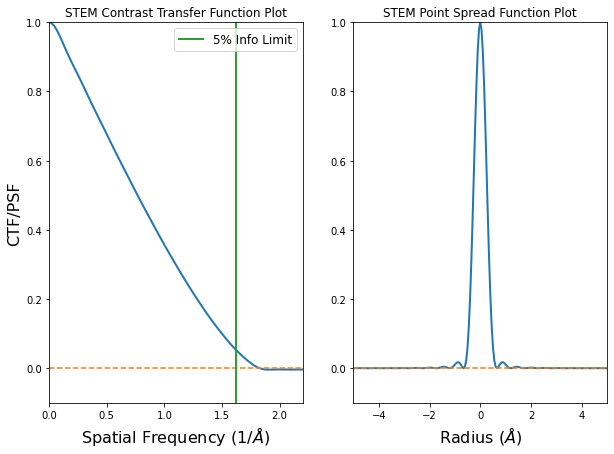

In [50]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,7])
    ctf, psf = f(k, init_energy, init_C3, init_C5, init_defocus, init_semiangle, 0)

    line1, = ax1.plot(k, ctf, lw=2)
    ax1.set_xlabel('Spatial Frequency (1/$\AA$)',fontsize = 16)
    ax1.set_ylabel('CTF/PSF', fontsize = 16)
    ax1.set_ylim([-0.1,1])
    ax1.set_title('STEM Contrast Transfer Function Plot')
    axcolor = 'lightgoldenrodyellow'
    ax1.margins(x = 0)
    ax1.axhline(y = 0, color ="C1", linestyle ="--")
    vline_5pct = ax1.axvline(x = k[np.where((ctf > 0.05) | (ctf < -0.05))[0][-1]], linewidth=2, 
                                 color= 'C2', label = '5% Info Limit')
    ax1.legend(fontsize = 12, loc = 'upper right')

    line2, = ax2.plot(r, psf, lw=2,color='#1f77b4')
    line22, = ax2.plot(-r, psf, lw=2,color='#1f77b4')
    ax2.set_xlabel('Radius ($\AA$)',fontsize = 16)
    # ax2.set_ylabel('PSF', fontsize = 16)
    ax2.set_ylim([-0.1,1])
    axcolor = 'lightgoldenrodyellow'
    ax2.margins(x = 0)
    ax2.axhline(y = 0, color ="C1", linestyle ="--")
    ax2.set_title('STEM Point Spread Function Plot')